In [201]:
import subprocess
import datetime
import os

import pandas as pd
from datetime import datetime


def gen_exec(cmd, check_return: bool = False):
    popen = subprocess.Popen(cmd, stdout=subprocess.PIPE, universal_newlines=True)
    for stdout_line in iter(popen.stdout.readline, ""):
        yield stdout_line
    popen.stdout.close()
    return_code = popen.wait()
    if return_code and check_return:
        raise subprocess.CalledProcessError(return_code, cmd)


def exec_bash(cmd: str, check_return: bool = False):
    return [s for s in gen_exec(cmd.split(), check_return)]
    
def exec_bash_print(cmd: str, check_return: bool = False):
    for path in gen_exec(cmd.split(), check_return):
        print(path, end="")
        
def strtime():
    return datetime.now().strftime("%y%m%d_%H%M%S")



from pathlib import Path

prj_path = Path(str(Path("../../../").resolve())+"/")
exp_folder = Path(prj_path, "papers/neurips21/")
res_folder = Path(exp_folder, "output")
model_folder = Path(exp_folder, "models")

jar_file = Path(prj_path, "target/credici-0.1.3-SNAPSHOT-jar-with-dependencies.jar")
javafile = Path(exp_folder, "Experiments.java")
#java = "/Library/Java/JavaVirtualMachines/openjdk-12.0.1.jdk/Contents/Home/bin/java"
java = "java"


print(prj_path)
print(exp_folder)
print(res_folder)
print(model_folder)

print(jar_file)

/root/dev/credici
/root/dev/credici/papers/neurips21
/root/dev/credici/papers/neurips21/output
/root/dev/credici/papers/neurips21/models
/root/dev/credici/target/credici-0.1.3-SNAPSHOT-jar-with-dependencies.jar


In [202]:
output_folder = Path(res_folder, "210516_102627")

In [203]:
resfiles = [f for f in os.listdir(output_folder) if f.endswith(".py")]
res_list = []

for r in resfiles:
    exec(Path(output_folder, r).read_text())
    res_list.append(results)

len(res_list)

80

In [204]:
from collections.abc import Iterable
import numpy as np



def to_pandas(res_dict):

    simple_cols = [c for c in res_dict.keys() if not isinstance(res_dict[c], Iterable) or isinstance(res_dict[c], str)]
    df1 = pd.DataFrame.from_dict({k:[res_dict[k]] for k in simple_cols})
    list_cols = [c for c in res_dict.keys() if c not in simple_cols]

    if len(list_cols)>1:
        df2 = pd.DataFrame.from_dict({k:res_dict[k] for k in list_cols})
        df = pd.concat([pd.concat([df1]*len(df2)).reset_index(drop=True), df2], axis=1)

    else:
        df = df1    

    df = df.reset_index(drop=False)
    df = df.rename(columns = dict(index="numPoints"))

    df["numPoints"] += 1

    df.columns

    columns = ['seed', 'markovian','error', 'nEndo','nExo', 'exoTW', 'errorMsg', 'folder', 'file', 'groundtruth',
              'timeBuild', 'timeExact', 'timeQuery',
              'pnsExact_l','pnsExact_u', 'pnsEM_l', 'pnsEM_u',  'numPoints','innerPoints', 'llkratio',
              'iterEM']

    columns = [c for c in columns if c in df.columns] + [c for c in df.columns if c not in columns]


    df = df[columns]
    return df

data = pd.concat([to_pandas(r) for r in res_list]).reset_index(drop=True)



In [205]:
# replace exact == -1 by NaN or None
data.loc[data.pnsExact_l == -1, "pnsExact_l"] = np.nan
data.loc[data.pnsExact_u == -1, "pnsExact_u"] = np.nan

# add exactEvaluable 

data["exact_eval"] = ~data["pnsExact_l"].isna()

# calculate RMSE


def rmse_pns(t): return np.sqrt((t["pnsEM_l"] - t["pnsExact_l"])**2 + (t["pnsEM_u"] - t["pnsExact_u"])**2)


data["rmse_pns"] = data.apply(rmse_pns, axis=1)

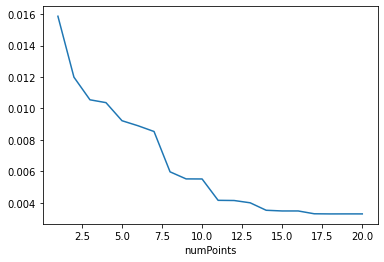

In [206]:
# plot RMSE vs numPoints
import matplotlib.pyplot as plt

def plot_rmse(data):
    df = data.dropna()
    df = df[["numPoints", "rmse_pns"]].groupby("numPoints").mean()
    df["rmse_pns"].plot()
    

plot_rmse(data[data["markovian"]==True])

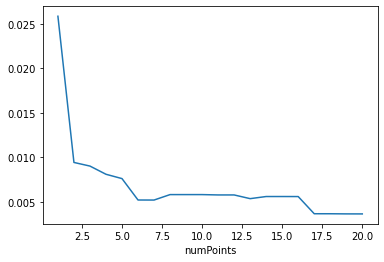

In [207]:
plot_rmse(data[data["markovian"]==False])

In [208]:
# plot share of compatible data
# plot histogram llk-ratio exactEvaluable or not exactEvaluable

In [154]:
data

,seed,markovian,error,nEndo,nExo,exoTW,errorMsg,folder,file,groundtruth,...,timeQuery,pnsExact_l,pnsExact_u,pnsEM_l,pnsEM_u,numPoints,innerPoints,llkratio,iterEM,exact_eval
0,0,False,False,6,3,1,,set1,chain_twExo1_nEndo6_1.uai,cve,...,37.0,NaN,NaN,0.006172,0.006172,1,0.0,0.000000,200.0,False
1,0,False,False,6,3,1,,set1,chain_twExo1_nEndo6_1.uai,cve,...,14.0,NaN,NaN,0.002469,0.006172,2,0.0,0.000000,200.0,False
2,0,False,False,6,3,1,,set1,chain_twExo1_nEndo6_1.uai,cve,...,13.0,NaN,NaN,0.002469,0.006172,3,0.0,0.000000,200.0,False
3,0,False,False,6,3,1,,set1,chain_twExo1_nEndo6_1.uai,cve,...,11.0,NaN,NaN,0.002469,0.030095,4,0.0,0.000000,200.0,False
4,0,False,False,6,3,1,,set1,chain_twExo1_nEndo6_1.uai,cve,...,11.0,NaN,NaN,0.002469,0.030095,5,0.0,0.000000,200.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,0,False,False,4,2,1,,set1,chain_twExo1_nEndo4_18.uai,cve,...,22.0,0.0,0.001548,0.000001,0.001581,16,0.0,0.998063,200.0,True
1337,0,False,False,4,2,1,,set1,chain_twExo1_nEndo4_18.uai,cve,...,22.0,0.0,0.001548,0.000001,0.001581,17,0.0,0.998099,105.0,True
1338,0,False,False,4,2,1,,set1,chain_twExo1_nEndo4_18.uai,cve,...,22.0,0.0,0.001548,0.000001,0.001581,18,0.0,0.998099,122.0,True
1339,0,False,False,4,2,1,,set1,chain_twExo1_nEndo4_18.uai,cve,...,24.0,0.0,0.001548,0.000001,0.001581,19,0.0,0.998002,200.0,True
